In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
from tqdm import tqdm_notebook as tqdm
import pickle
import IPython.display as ipd
%matplotlib inline

In [2]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


# Segmentation tests

## Neural network for onset detection

In [3]:
%run ../Utilities/Utilities.ipynb

In [4]:
def check_onsets(file):
    y = load_file(file, 8000)
    model1 = load_NN("Guitar_onset_300", verbose=False)
    model2 = load_NN("Guitar_onset_600", verbose=False)
    model3 = load_NN("Guitar_onset_spectral_300", verbose=False)
    model4 = load_NN("Guitar_onset_spectral_600", verbose=False)
    
    results1 = apply_window(y, size=300, disp=100, function=model1.predict, convert=True)
    results1 = np.array(results1)
    final = []
    for x in results1:
        final.append([x[0], x[1][0][0]])
    final = np.array(final)
    
    results2 = apply_window(y, size=600, disp=100, function=model2.predict, convert=True)
    results2 = np.array(results2)
    final2 = []
    for x in results2:
        final2.append([x[0], x[1][0][0]])
    final2 = np.array(final2)
    
    results3 = apply_window(y, size=300, disp=100, function=model3.predict, convert=True, temp=False)
    results3 = np.array(results3)
    final3 = []
    for x in results3:
        final3.append([x[0], x[1][0][0]])
    final3 = np.array(final3)
    
    results4 = apply_window(y, size=600, disp=100, function=model4.predict, convert=True, temp=False)
    results4 = np.array(results4)
    final4 = []
    for x in results4:
        final4.append([x[0], x[1][0][0]])
    final4 = np.array(final4)
    
    previous = np.array([])
    all_onsets = []
    for narrow_temp, broad_temp, narrow_spectral, broad_spectral in zip(final, final2, final3, final4):
        preds = np.append(previous, np.array([broad_temp[1], narrow_temp[1], broad_spectral[1], narrow_spectral[1]]))
        previous = np.array([broad_temp[1], narrow_temp[1], broad_spectral[1], narrow_spectral[1]])
        if ((preds >= 0.8).sum() >= 3) or ((preds >= 0.95).sum() >= 1):
            all_onsets.append(narrow_temp[0]+150)
    
    final_onsets = []
    for i in range(len(all_onsets) - 1):
        if all_onsets[i+1] - all_onsets[i] > 100:
            final_onsets.append(all_onsets[i])
    final_onsets.append(all_onsets[-1])
    
    plt.figure(figsize=(18,6))
    plt.plot(y, alpha=.7)
    for o in final_onsets:
        plt.axvline(x=o, color='r', linestyle='--')
        
    plt.figure(figsize=(18,6))
    plt.plot(y*3, alpha=.7)
    plt.plot(final[:,0]+150, final[:,1], 'r', linewidth=2)
    plt.plot(final2[:,0]+300, final2[:,1]*(-1), 'purple', linewidth=2)
    plt.axhline(y=0.8, color="b", linestyle='--')
    plt.axhline(y=-0.8, color="b", linestyle='--')
    for narrow, broad in zip(final, final2):
        if (broad[1] >= 0.8) and (narrow[1] >= 0.8):
            plt.axvline(x=narrow[0]+150, color='g', linestyle='--')
            
    plt.figure(figsize=(18,6))
    plt.plot(y*3, alpha=.7)
    plt.plot(final3[:,0]+150, final3[:,1], 'r', linewidth=2)
    plt.plot(final4[:,0]+300, final4[:,1]*(-1), 'purple', linewidth=2)
    plt.axhline(y=0.8, color="b", linestyle='--')
    plt.axhline(y=-0.8, color="b", linestyle='--')
    for narrow, broad in zip(final3, final4):
        if (broad[1] >= 0.8) and (narrow[1] >= 0.8):
            plt.axvline(x=narrow[0]+150, color='g', linestyle='--')

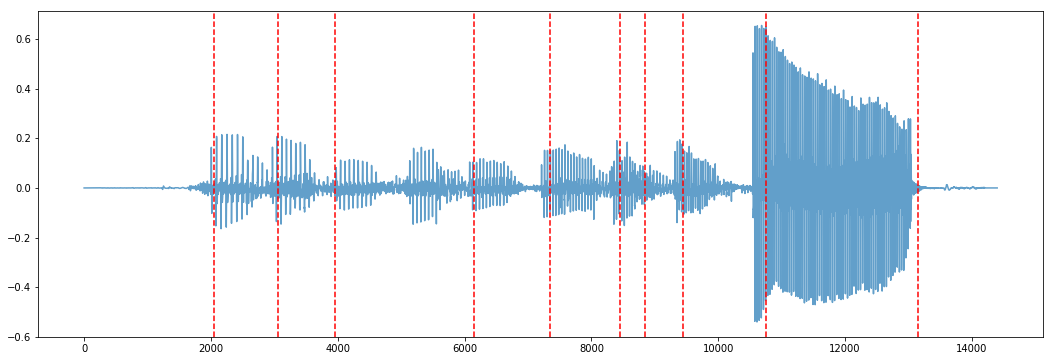

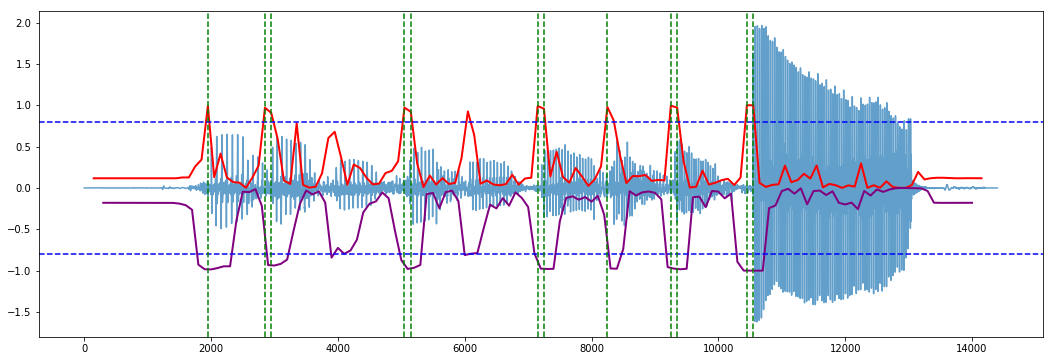

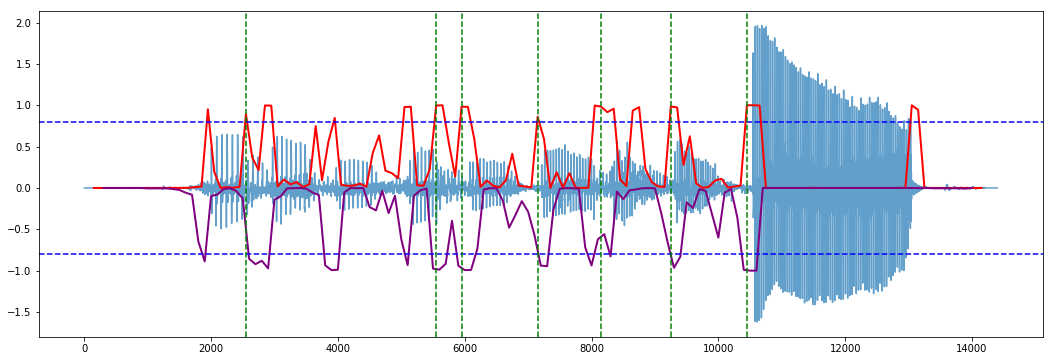

In [28]:
check_onsets("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3")

In [17]:
performance = pd.DataFrame()

In [32]:
performance = performance.append(pd.DataFrame({
    "Riff": ["2"],
    "TP": [16],
    "FP": [2],
    "FN": [0]
}))

## NN + envelope

In [3]:
%run ../Utilities/Utilities.ipynb

In [4]:
def onset_detector(y, model, bins=80, k=1.5, size=500, disp=800, use_desc=False):
    env_pos, env_neg = envelope(y, bins)
    onsets = frontiers(y, env_pos, k, use_desc)
    filtered_onsets = []
    final_onsets = []
    
    # Remove unusually short candidates
    for t, o in zip((onsets[1:]-onsets[:-1]), onsets):
        if t >= 0.25 * np.mean(onsets[1:]-onsets[:-1]):
            filtered_onsets.append(o)
    
    try:
        filtered_onsets.append(len(y[::-1][np.argwhere(y[::-1] >= 0.02)[0][0]:]))
    except:
        pass
    
    for i in tqdm(range(len(filtered_onsets) - 1), leave = False):
        chunk = y[filtered_onsets[i]:filtered_onsets[i+1]]
        chunk = chunk[size:len(chunk)-size]
        predictions = apply_window(chunk, size=size, disp=disp, convert=True, temp=True, 
                                   norm=False, function=model.predict)
        
        final_onsets.append(filtered_onsets[i])
        
        for j in range(0, len(predictions) - 1):
            n = predictions[j][0]
            current_note = np.argmax(predictions[j][1][0])
            next_note = np.argmax(predictions[j+1][1][0])
            
            if (current_note != next_note) and ((len(chunk) - n - size/2) >= (0.05 * len(chunk))):
                final_onsets.append(int(filtered_onsets[i] + n + 3*size/2))
    
    if len(filtered_onsets) > 0:
        final_onsets.append(filtered_onsets[-1])
    
    return final_onsets

In [5]:
def middle_check(chunk, center, std, model, final_onsets):
    new_candidates = np.array(onset_detector(chunk, model, bins=20, use_desc=True))
    return np.mean(new_candidates[round_to_base(new_candidates, std) == center])

In [51]:
def final_check(y, model, final_onsets):
    std = int(np.std(np.array(final_onsets[1:]) - np.array(final_onsets[:-1])))
    rounded = np.array([round_to_base(_, std) for _ in (np.array(final_onsets[1:]) - np.array(final_onsets[:-1]))])
    center = np.median(rounded)
    
    if center != 0:
        new = np.array(apply_window(y, int(2*center), int(2*center), middle_check, False, False, False,
                                    center, std, model, final_onsets))
        new = new[:,0] + new[:,1]
        new = new[~np.isnan(new)]
        rounded_new = round_to_base(new, 2*std)
    
        for a, b in zip(new, rounded_new):
            if b not in round_to_base(final_onsets, 2*std):
                final_onsets.append(int(a))

    return final_onsets

In [7]:
def segment(y, model, bins=80, k=1.5, size=500, disp=600):
    onsets = onset_detector(y, model, bins, k, size, disp)
    final_onsets = final_check(y, model, onsets)
    return final_onsets

In [8]:
def min_dist(x, arr):
    arr = np.array(arr)
    return np.min(np.abs(arr - x))

In [9]:
def check_onsets(file):
    y = load_file(file, 8000)
    model1 = load_NN("Guitar_onset_300", verbose=False)
    model2 = load_NN("Guitar_onset_600", verbose=False)
    model3 = load_NN("Guitar_onset_spectral_300", verbose=False)
    model4 = load_NN("Guitar_onset_spectral_600", verbose=False)
    
    results1 = apply_window(y, size=300, disp=100, function=model1.predict, convert=True)
    results1 = np.array(results1)
    final = []
    for x in results1:
        final.append([x[0], x[1][0][0]])
    final = np.array(final)
    
    results2 = apply_window(y, size=600, disp=100, function=model2.predict, convert=True)
    results2 = np.array(results2)
    final2 = []
    for x in results2:
        final2.append([x[0], x[1][0][0]])
    final2 = np.array(final2)
    
    results3 = apply_window(y, size=300, disp=100, function=model3.predict, convert=True, temp=False)
    results3 = np.array(results3)
    final3 = []
    for x in results3:
        final3.append([x[0], x[1][0][0]])
    final3 = np.array(final3)
    
    results4 = apply_window(y, size=600, disp=100, function=model4.predict, convert=True, temp=False)
    results4 = np.array(results4)
    final4 = []
    for x in results4:
        final4.append([x[0], x[1][0][0]])
    final4 = np.array(final4)
    
    note_NN = load_NN("../Single_note_models/Guitar/Guitar", verbose=0)
    final5 = segment(y, note_NN)
    
    previous = np.array([])
    previous_1 = np.array([])
    all_onsets = []
    l = []
    for narrow_temp, broad_temp, narrow_spectral, broad_spectral in zip(final, 
                                                                        final2, 
                                                                        final3, 
                                                                        final4):
        preds = np.append(previous_1, previous)
        preds = np.append(preds, np.array([broad_temp[1], 
                                              narrow_temp[1], 
                                              broad_spectral[1], 
                                              narrow_spectral[1]]))
        previous_1 = previous
        previous = np.array([broad_temp[1], 
                             narrow_temp[1], 
                             broad_spectral[1], 
                             narrow_spectral[1]])
        
        if (((preds >= 0.75).sum() >= 2) and (min_dist(int(narrow_temp[0]+150), final5) <= 200) or
               (((preds >= 0.85).sum() >= 2) and ((np.argwhere(preds >= 0.85)[1] - np.argwhere(preds >= 0.85)[0]) != 4))):
            all_onsets.append(narrow_temp[0]+150)
    
    final_onsets = []
    coinc = []
    
    for i in range(len(all_onsets) - 1):
        if all_onsets[i+1] - all_onsets[i] > 200 or len(coinc) >= 6:
            coinc.append(all_onsets[i])
            final_onsets.append(np.array(coinc).mean())
            coinc = []
        else:
            coinc.append(all_onsets[i])
    final_onsets.append(all_onsets[-1])
    
    plt.figure(figsize=(18,6))
    plt.plot(y, alpha=.7)
    for o in final_onsets:
        plt.axvline(x=o, color='r', linestyle='--')
        
    plt.figure(figsize=(18,6))
    plt.plot(y*3, alpha=.7)
    plt.plot(final[:,0]+150, final[:,1], 'r', linewidth=2)
    plt.plot(final2[:,0]+300, final2[:,1]*(-1), 'purple', linewidth=2)
    plt.axhline(y=0.75, color="b", linestyle='--')
    plt.axhline(y=-0.75, color="b", linestyle='--')
    plt.axhline(y=0.85, color="b", linestyle='--')
    plt.axhline(y=-0.85, color="b", linestyle='--')
    for narrow, broad in zip(final, final2):
        if (broad[1] >= 0.8) and (narrow[1] >= 0.8):
            plt.axvline(x=narrow[0]+150, color='g', linestyle='--')
            
    plt.figure(figsize=(18,6))
    plt.plot(y*3, alpha=.7)
    plt.plot(final3[:,0]+150, final3[:,1], 'r', linewidth=2)
    plt.plot(final4[:,0]+300, final4[:,1]*(-1), 'purple', linewidth=2)
    plt.axhline(y=0.75, color="b", linestyle='--')
    plt.axhline(y=-0.75, color="b", linestyle='--')
    plt.axhline(y=0.85, color="b", linestyle='--')
    plt.axhline(y=-0.85, color="b", linestyle='--')
    for narrow, broad in zip(final3, final4):
        if broad[1] > 0.8 or narrow[1] > 0.8:
            l.append([narrow[0]+150, broad[1], narrow[1]])
        if (broad[1] >= 0.8) and (narrow[1] >= 0.8):
            plt.axvline(x=narrow[0]+150, color='g', linestyle='--')
            
    plt.figure(figsize=(18,6))
    plt.plot(y)
    for i in final5:
        plt.axvline(x=i, color="g")

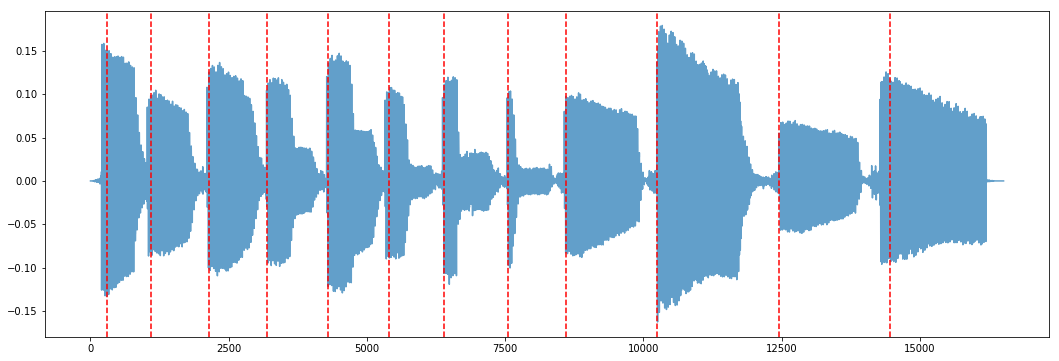

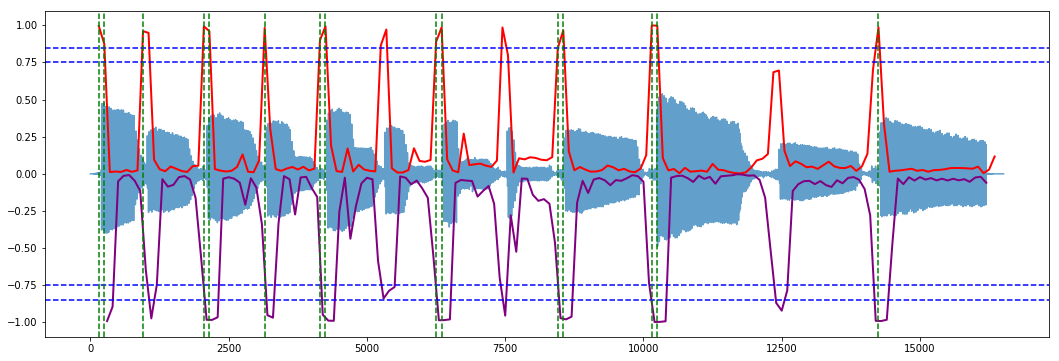

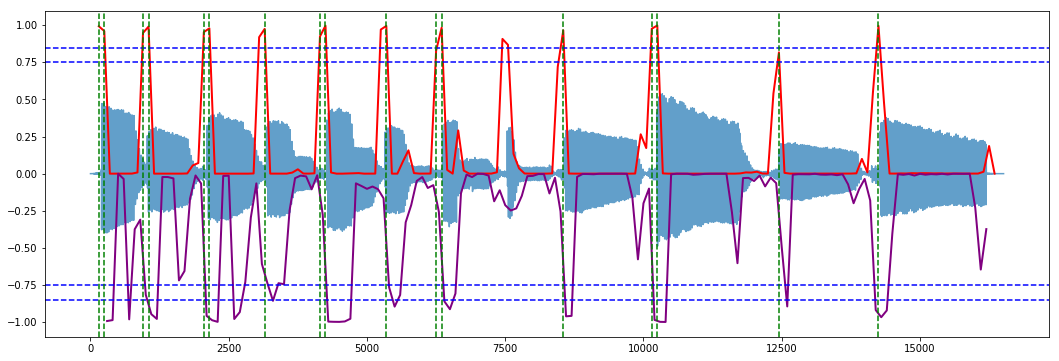

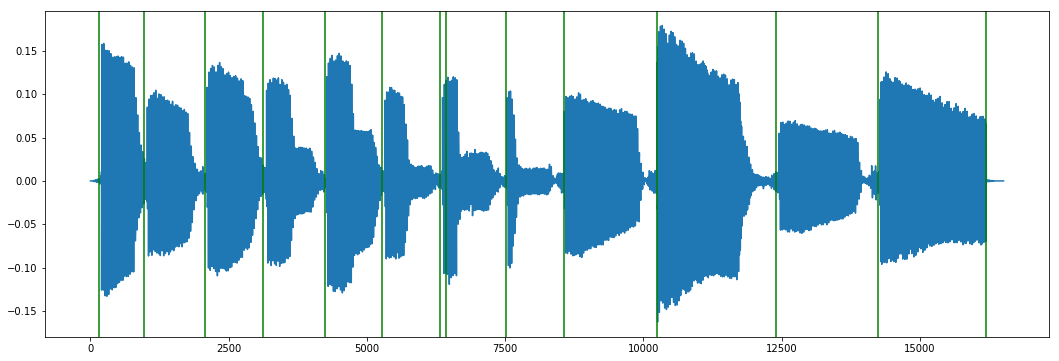

In [62]:
check_onsets("../Samples/Guitar/Riffs/Guitar_noamp_riff15_3.mp3")

In [139]:
seg_metrics = pd.read_csv("seg_metrics.tsv", sep="\t", header=0)

In [141]:
precision = seg_metrics["TP"].sum() / (seg_metrics["TP"].sum() + seg_metrics["FP"].sum())
recall = seg_metrics["TP"].sum() / (seg_metrics["TP"].sum() + seg_metrics["FN"].sum())
print("Precision: ", precision)
print("Recall: ", recall)

Precision:  0.9678899082568807
Recall:  0.9890625


## Using envelopes to detect note onsets

In [4]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3", 8000)

In [5]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff9.mp3")

In [6]:
env_pos, env_neg = envelope(y, 80)
onsets = frontiers(y, env_pos, 1.5)

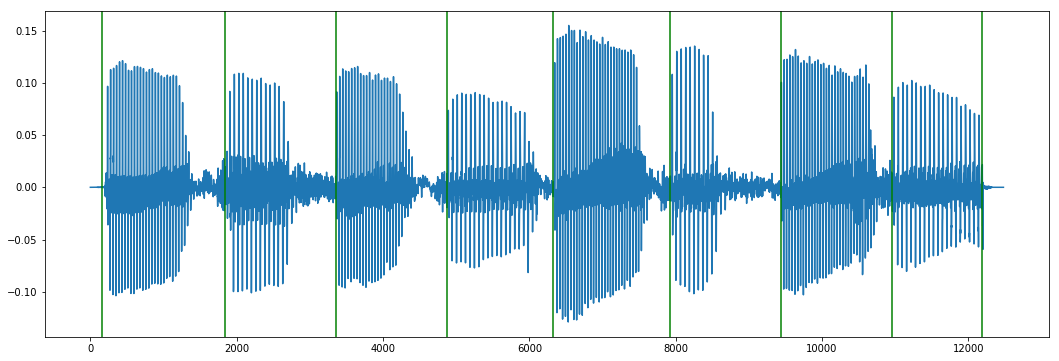

In [7]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in onsets:
    plt.axvline(x=i, color="g")

Correct segmentation

In [65]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", 8000)

In [66]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3")

In [67]:
env_pos, env_neg = envelope(y, 80)
onsets = frontiers(y, env_pos, 1.5)

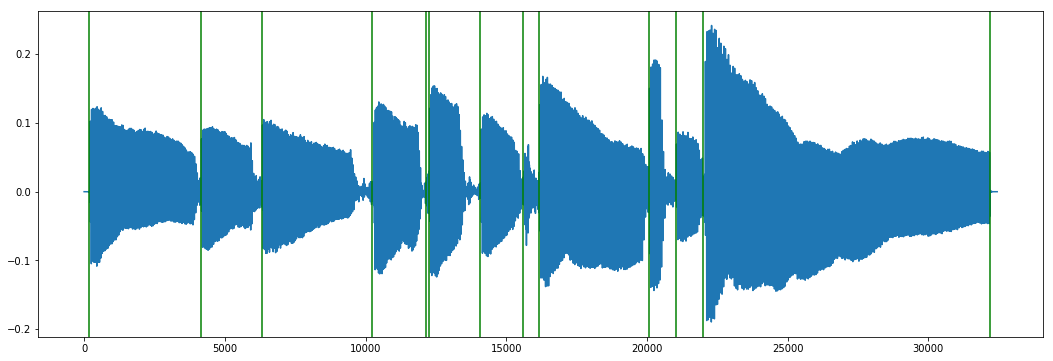

In [68]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in onsets:
    plt.axvline(x=i, color="g")

It picks up false onsets

In [69]:
onsets[1:]-onsets[:-1]

array([ 4000,  2160,  3920,  1920,    80,  1840,  1520,   560,  3920,
         960,   960, 10181], dtype=int64)

In [70]:
np.mean(onsets[1:]-onsets[:-1])

2668.4166666666665

We can filter out unusually short "notes"

In [71]:
filtered_onsets = []
for t, o in zip((onsets[1:]-onsets[:-1]), onsets):
    if t >= 0.25 * np.mean(onsets[1:]-onsets[:-1]):
        filtered_onsets.append(o)
filtered_onsets.append(len(y[::-1][np.argwhere(y[::-1] >= 0.02)[0][0]:]))

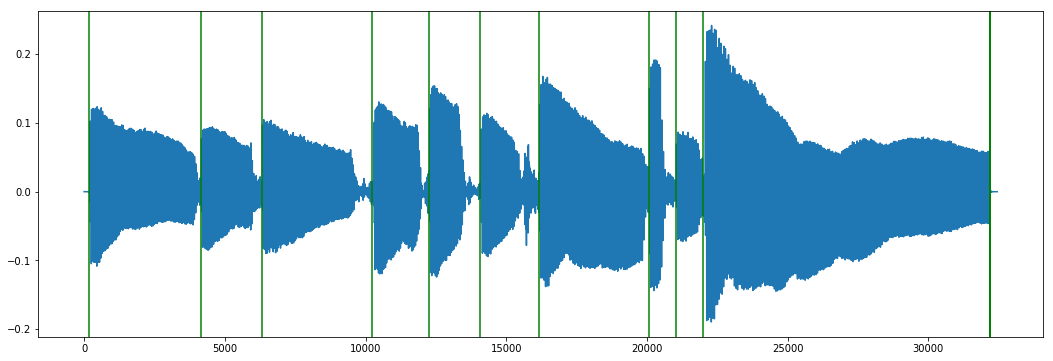

In [72]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in filtered_onsets:
    plt.axvline(x=i, color="g")

Now it works

In [73]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3", 8000)

In [74]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3")

In [75]:
env_pos, env_neg = envelope(y, 80)
onsets = frontiers(y, env_pos, 1.5)

In [76]:
np.mean(onsets[1:]-onsets[:-1])

1595.9

In [77]:
filtered_onsets = []
for t, o in zip((onsets[1:]-onsets[:-1]), onsets):
    if t >= 0.25 * np.mean(onsets[1:]-onsets[:-1]):
        filtered_onsets.append(o)
filtered_onsets.append(len(y[::-1][np.argwhere(y[::-1] >= 0.02)[0][0]:]))

In [78]:
onsets

array([  239,  2079,  4159,  6079,  8079,  9839,  9999, 10079, 12079,
       14079, 16079, 17839, 17919, 20079, 21999, 24159, 26079, 28239,
       29999, 30159, 32157], dtype=int64)

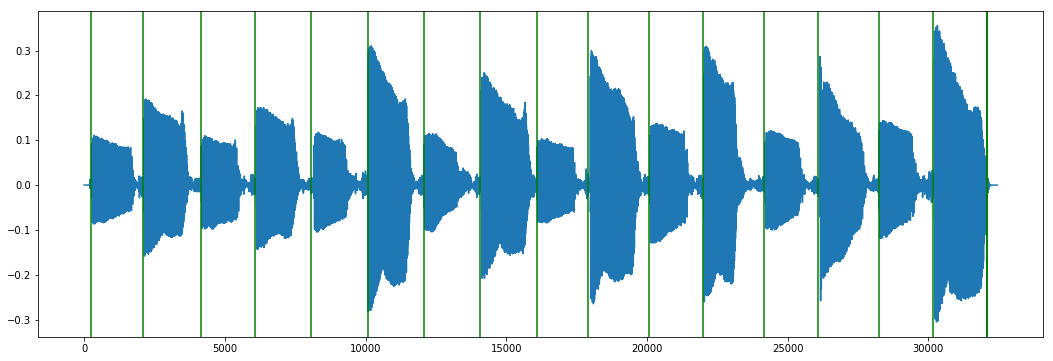

In [79]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in filtered_onsets:
    plt.axvline(x=i, color="g")

Correct segmentation

In [80]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3", 8000)

In [81]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3")

In [82]:
env_pos, env_neg = envelope(y, 80)
onsets = frontiers(y, env_pos, 1.5)

In [83]:
filtered_onsets = []
for t, o in zip((onsets[1:]-onsets[:-1]), onsets):
    if t >= 0.25 * np.mean(onsets[1:]-onsets[:-1]):
        filtered_onsets.append(o)
filtered_onsets.append(len(y[::-1][np.argwhere(y[::-1] >= 0.02)[0][0]:]))

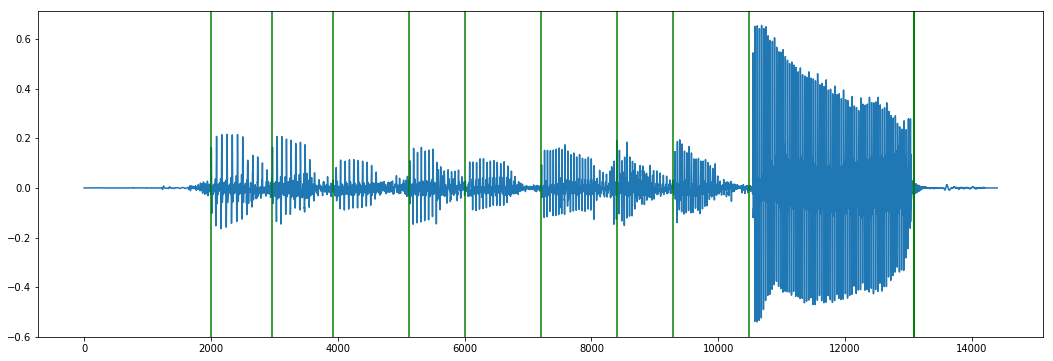

In [84]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in filtered_onsets:
    plt.axvline(x=i, color="g")

Correct segmentation

In [6]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff4.mp3", 8000)

In [278]:
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff4.mp3")

In [100]:
env_pos, env_neg = envelope(y, 80)
onsets = frontiers(y, env_pos, 1.5)

In [101]:
filtered_onsets = []
for t, o in zip((onsets[1:]-onsets[:-1]), onsets):
    if t >= 0.25 * np.mean(onsets[1:]-onsets[:-1]):
        filtered_onsets.append(o)
filtered_onsets.append(len(y[::-1][np.argwhere(y[::-1] >= 0.02)[0][0]:]))

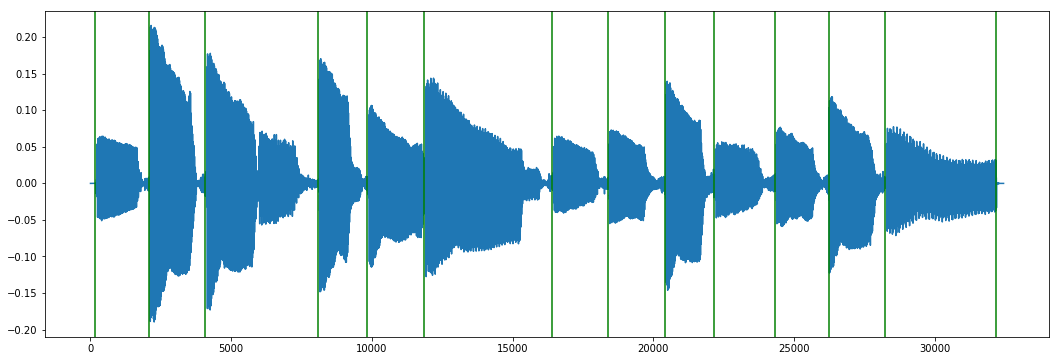

In [102]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in filtered_onsets:
    plt.axvline(x=i, color="g")

Here it misses the 4th note

## Envelopes and note checking

We can use the note classifier NN to check whether there are actually two different notes between two onsets (i.e. check whether it has missed a note)

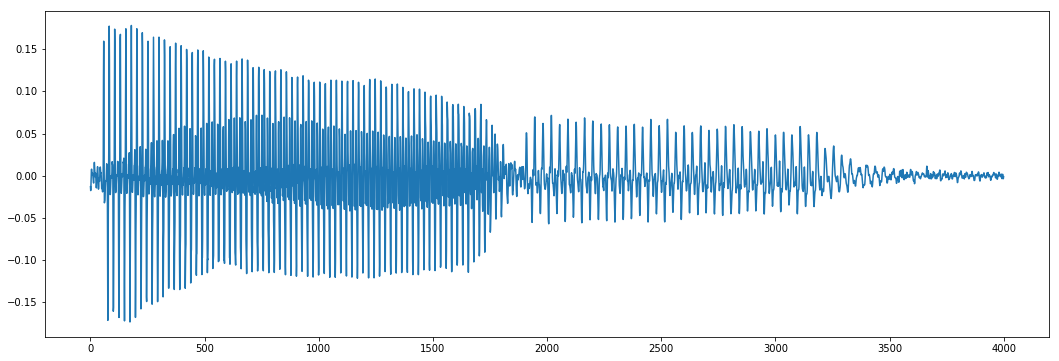

In [104]:
plt.figure(figsize=(18,6))
plt.plot(y[filtered_onsets[2]:filtered_onsets[3]])

In [5]:
note_NN = load_NN("../Single_note_models/Guitar/Guitar")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 500)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               128256    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 61)                7869      
Total params: 169,021
Trainable params: 169,021
Non-trainable params: 0
_________________________________________________________________


In [110]:
results = apply_window(y[filtered_onsets[2]:filtered_onsets[3]], size=500, disp=200, temp=True, 
                       norm=False, function=note_NN.predict)

In [146]:
for i in range(len(results) - 1):
    if (np.argmax(results[i][1][0]) != np.argmax(results[i+1][1][0])) and ((len(y[filtered_onsets[2]:filtered_onsets[3]]) - results[i][0] - 250) >= (0.05 * len(y))):
        print(results[i][0] + 250)

1650


In [7]:
def onset_detector(y, model, bins=80, k=1.5, size=500, disp=800, use_desc=False):
    # Find onset candidates
    env_pos, env_neg = envelope(y, bins)
    onsets = frontiers(y, env_pos, k, use_desc)
    filtered_onsets = []
    final_onsets = []
    
    # Remove unusually short candidates
    for t, o in zip((onsets[1:]-onsets[:-1]), onsets):
        if t >= 0.25 * np.mean(onsets[1:]-onsets[:-1]):
            filtered_onsets.append(o)
    filtered_onsets.append(len(y[::-1][np.argwhere(y[::-1] >= 0.02)[0][0]:]))
    
    # Check whether there are multiple notes between two candidates
    for i in tqdm(range(len(filtered_onsets) - 1), leave = False):
        
        # Apply note prediction between every two candidates
        chunk = y[filtered_onsets[i]:filtered_onsets[i+1]]
        chunk = chunk[size:len(chunk)-size]
        predictions = apply_window(chunk, size=size, disp=disp, convert=True, temp=True, 
                                   norm=False, function=model.predict)
        final_onsets.append(filtered_onsets[i])
        
        # Check whether the predicted note changes
        for j in range(0, len(predictions) - 1):
            n = predictions[j][0]
            current_note = np.argmax(predictions[j][1][0])
            next_note = np.argmax(predictions[j+1][1][0])
            
            if (current_note != next_note) and ((len(chunk) - n - size/2) >= (0.05 * len(chunk))):
                final_onsets.append(int(filtered_onsets[i] + n + 3*size/2))
    
    final_onsets.append(filtered_onsets[-1])
    
    return final_onsets

In [10]:
final_onsets = onset_detector(y, note_NN)

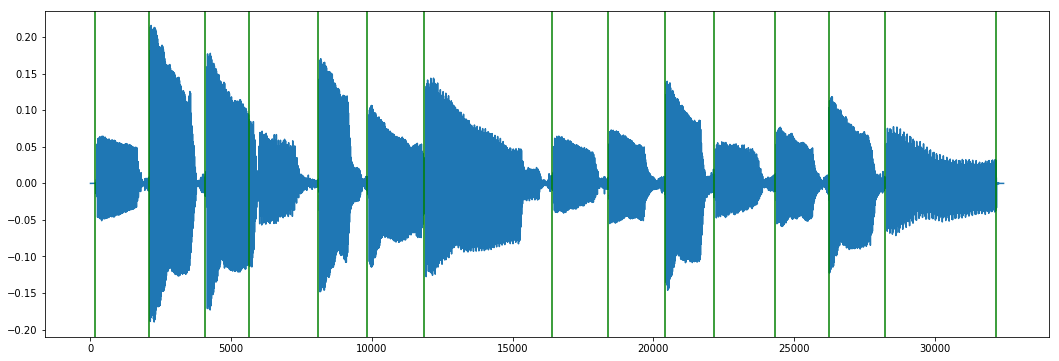

In [11]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Perfect!

Now let's test it over some riffs

In [290]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", 8000)
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3")

In [291]:
final_onsets = onset_detector(y, note_NN)

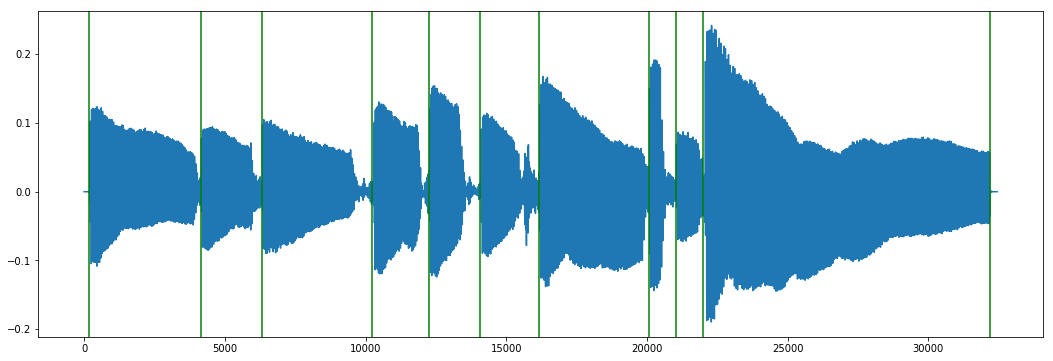

In [292]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Correct

In [293]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3", 8000)
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff2.mp3")

In [294]:
final_onsets = onset_detector(y, note_NN)

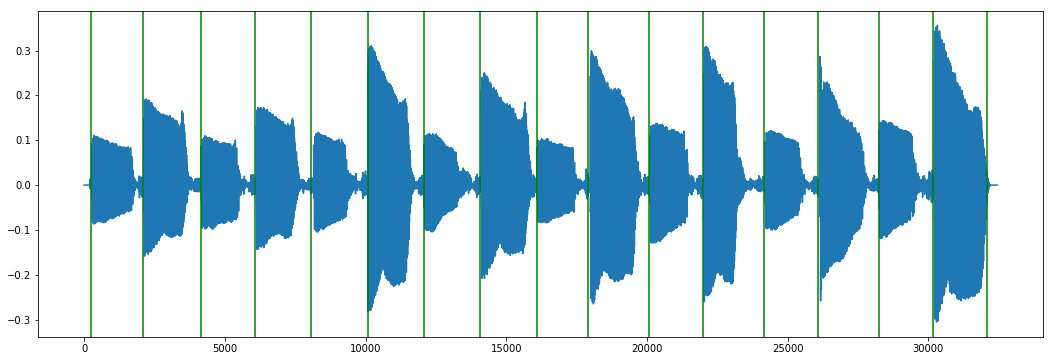

In [295]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Correct

In [296]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3", 8000)
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff3.mp3")

In [297]:
final_onsets = onset_detector(y, note_NN, disp=600)

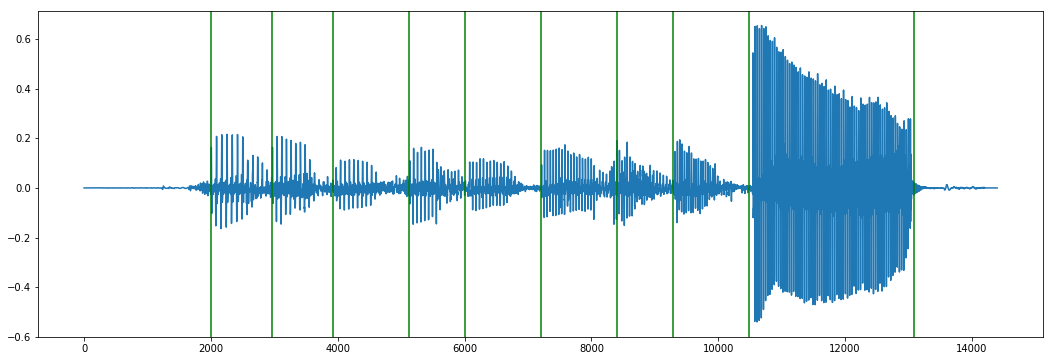

In [298]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Correct

In [6]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff5.mp3", 8000)
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff5.mp3")

In [98]:
final_onsets = onset_detector(y, note_NN, disp=600)

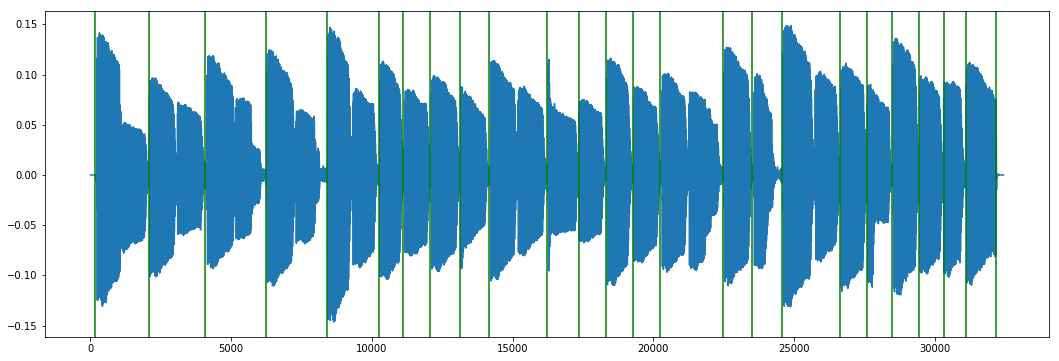

In [99]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Misses a few notes

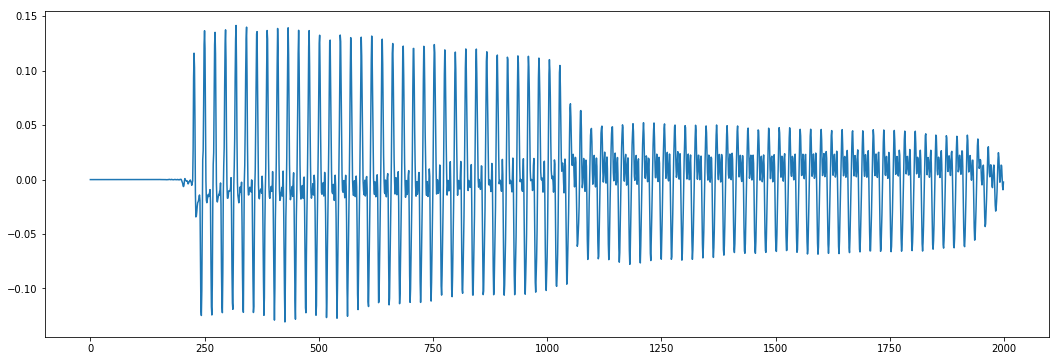

In [15]:
plt.figure(figsize=(18,6))
plt.plot(y[:2000])

Standard deviation of note length

In [26]:
std = int(np.std(np.array(final_onsets[1:]) - np.array(final_onsets[:-1])))

Round durations to the standard deviation

In [27]:
rounded = np.array([round_to_base(a, std) for a in (np.array(final_onsets[1:]) - np.array(final_onsets[:-1]))])

Pick the most common value

In [28]:
np.median(rounded)

1044.0

The idea now is to check windows of double this value and check if there is a candidate around the center (using more accurate envelopes)

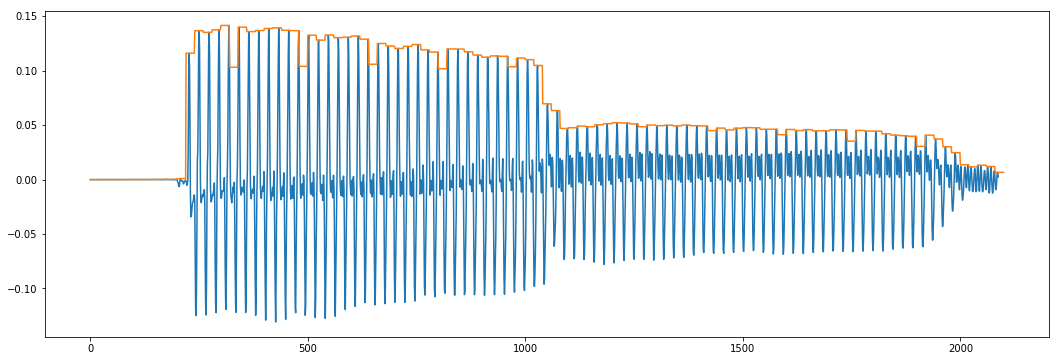

In [68]:
plt.figure(figsize=(18,6))
plt.plot(y[:2*1044])
plt.plot(envelope(y[:2*1044], 20)[0])

Re-run onset detector on the window with a more accurate envelope and allowing amplitude falls

In [30]:
new_candidates = onset_detector(y[:2*1044], note_NN, bins=20, use_desc=True)
new_candidates = np.array(new_candidates)
new_candidates

array([ 219, 1039, 1990], dtype=int64)

In [31]:
round_to_base(new_candidates, std)

array([   0., 1044., 2088.])

Pick only those that are close to the middle point

In [32]:
new_candidates[round_to_base(new_candidates, std) == 1044]

array([1039], dtype=int64)

In [11]:
def middle_check(chunk, center, std, model, final_onsets):
    new_candidates = np.array(onset_detector(chunk, model, bins=20, use_desc=True))
    return np.mean(new_candidates[round_to_base(new_candidates, std) == center])

In [34]:
middle_check(y[:2*1044], 1044, std, note_NN)

1039.0

In [18]:
def final_check(y, model, final_onsets):
    std = int(np.std(np.array(final_onsets[1:]) - np.array(final_onsets[:-1])))
    rounded = np.array([round_to_base(_, std) for _ in (np.array(final_onsets[1:]) - np.array(final_onsets[:-1]))])
    center = np.median(rounded)
    new = np.array(apply_window(y, int(2*center), int(2*center), middle_check, False, False, False,
                                center, std, model, final_onsets))
    new = new[:,0] + new[:,1]
    new = new[~np.isnan(new)]
    rounded_new = round_to_base(new, 2*std)
    
    for a, b in zip(new, rounded_new):
        if b not in round_to_base(final_onsets, 2*std):
            final_onsets.append(int(a))

    return final_onsets

In [26]:
final_onsets = onset_detector(y, note_NN, disp=600)

In [20]:
final_onsets = final_check(y, note_NN, final_onsets)

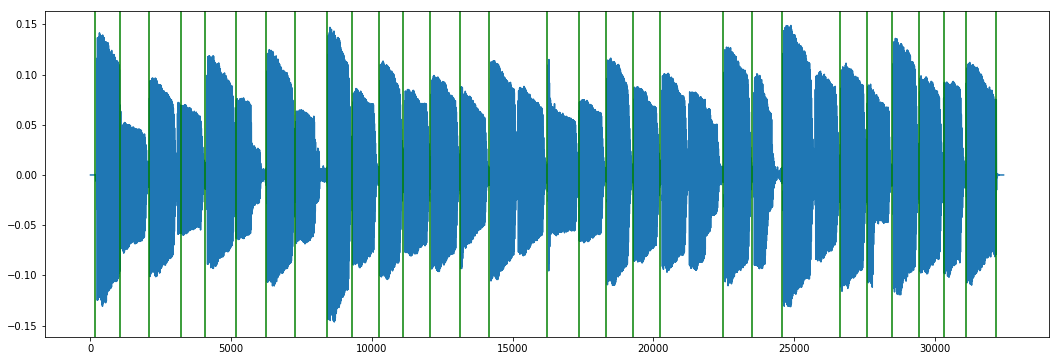

In [21]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Still misses 3 notes but it performs better overall

Now let's group it into one function

In [36]:
def segment(y, model, bins=80, k=1.5, size=500, disp=600):
    onsets = onset_detector(y, model, bins, k, size, disp)
    final_onsets = final_check(y, model, onsets)
    return final_onsets

And test it

In [39]:
y = load_file("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3", 8000)
ipd.Audio("../Samples/Guitar/Riffs/Guitar_noamp_riff1.mp3")

In [40]:
final_onsets = segment(y, note_NN)

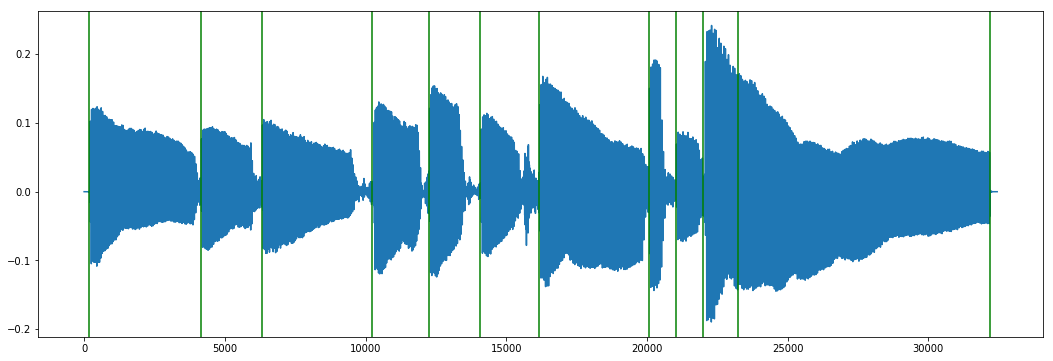

In [41]:
plt.figure(figsize=(18,6))
plt.plot(y)
for i in final_onsets:
    plt.axvline(x=i, color="g")

Here it picks up a false onset

To sum up:
1. Find onset candidates using the wave envelope.
2. Remove unusually short note candidates.
3. Check whether there is a missed note using note detection.
4. Check whether there is a missed note using more accurate envelopes.